C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5612\2805713318.py:65: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  manchester_polygon = gdf_combined.unary_union


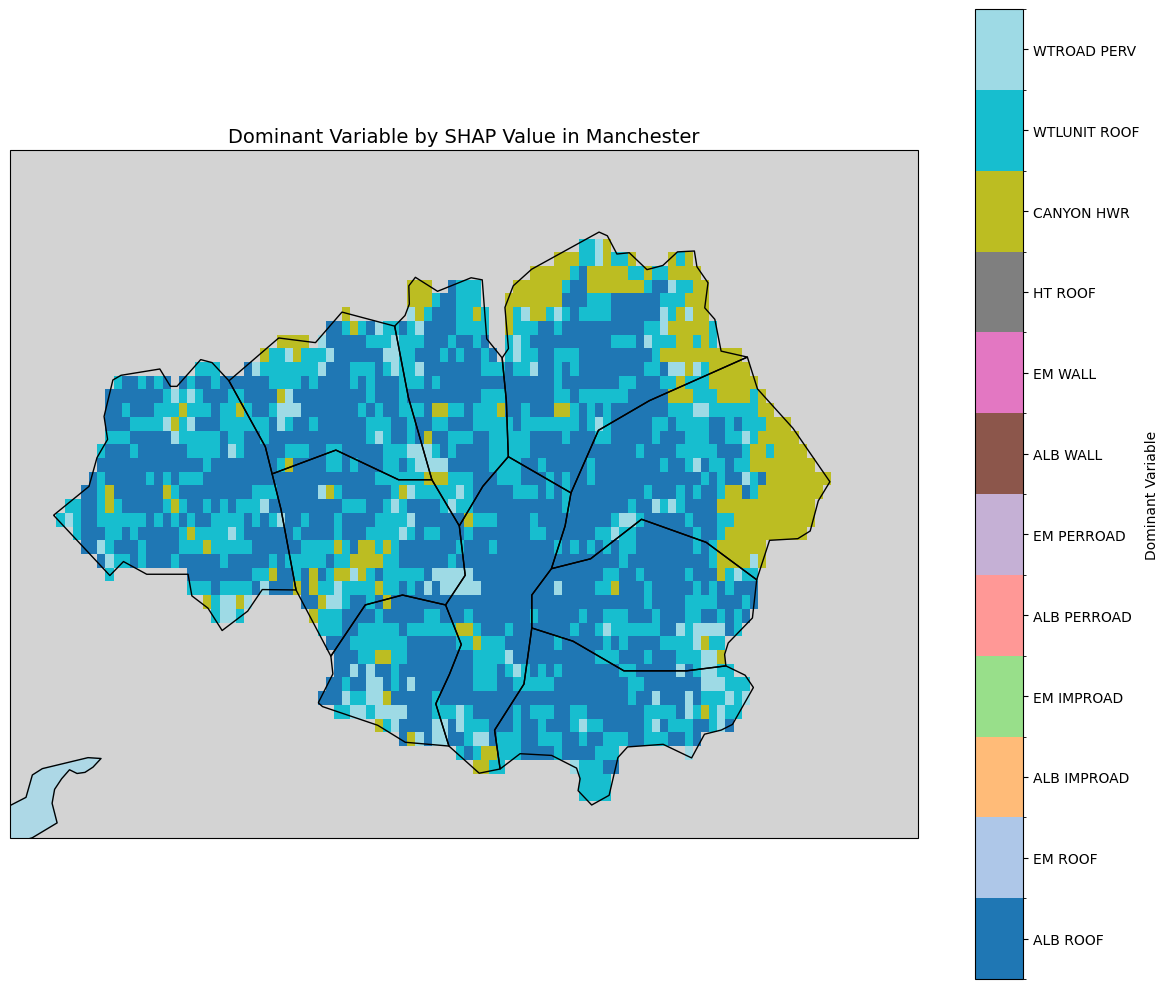

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
import pandas as pd

# Load SHAP values
target_name = 'TSAmax'
shap_values = np.load(f'ERP_automl_model_{target_name}_shap.npy')  # shape = (n_samples, n_features)

# Feature names (12 variables)
feature_names = [
    'ALB ROOF',     # 0
    'EM ROOF',      # 1
    'ALB IMPROAD',  # 2
    'EM IMPROAD',   # 3
    'ALB PERROAD',  # 4
    'EM PERROAD',   # 5
    'ALB WALL',     # 6
    'EM WALL',      # 7
    'HT ROOF',      # 8
    'CANYON HWR',   # 9
    'WTLUNIT ROOF', # 10
    'WTROAD PERV',  # 11
]

# Read lon/lat from netCDF
nc_albroof = Dataset('D:\\A_sem2\\ERP\\Simulation\\USurf_1km_netcdf\\USurf_1km_netcdf\\global_ALB_ROOF_1km_masked_gapfilled_QC.nc', mode='r')
lon = nc_albroof.variables['lon'][:]
lat = nc_albroof.variables['lat'][:]
nc_albroof.close()

# Find lon/lat index ranges for the Manchester bbox
lon_mask = (lon >= -2.8) & (lon <= -1.8)
lat_mask = (lat >= 53.3) & (lat <= 53.75)
lon_idx = np.where(lon_mask)[0]
lat_idx = np.where(lat_mask)[0]

# Extract Manchester lon/lat and make 2D grids
lon_Man = lon[lon_idx]
lat_Man = lat[lat_idx]
lon_grid, lat_grid = np.meshgrid(lon_Man, lat_Man)

# Load shapefile and select Manchester-area administrative units
shapefile_path = "D:/A_sem2/ERP/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
gdf = gpd.read_file(shapefile_path)

g1 = gdf[(gdf['name'] == 'Manchester') & (gdf['iso_a2'] == 'GB')]
g2 = gdf[(gdf['name'] == 'Stockport') & (gdf['iso_a2'] == 'GB')]
g3 = gdf[(gdf['name'] == 'Wigan') & (gdf['iso_a2'] == 'GB')]
g4 = gdf[(gdf['name'] == 'Bolton') & (gdf['iso_a2'] == 'GB')]
g5 = gdf[(gdf['name'] == 'Salford') & (gdf['iso_a2'] == 'GB')]
g6 = gdf[(gdf['name'] == 'Trafford') & (gdf['iso_a2'] == 'GB')]
g7 = gdf[(gdf['name'] == 'Tameside') & (gdf['iso_a2'] == 'GB')]
g8 = gdf[(gdf['name'] == 'Oldham') & (gdf['iso_a2'] == 'GB')]
g9 = gdf[(gdf['name'] == 'Rochdale') & (gdf['iso_a2'] == 'GB')]
g10 = gdf[(gdf['name'] == 'Bury') & (gdf['iso_a2'] == 'GB')]

gdf_combined = gpd.GeoDataFrame(pd.concat([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10], axis=0), crs=gdf.crs)
manchester_polygon = gdf_combined.unary_union

# Function to mask data inside polygon
def mask_data_inside_polygon(lon_grid, lat_grid, data_array, polygon):
    points = [Point(x, y) for x, y in zip(lon_grid.flatten(), lat_grid.flatten())]
    mask = np.array([polygon.contains(pt) for pt in points])
    filtered_data = np.full(data_array.size, np.nan)
    filtered_data[mask] = data_array.flatten()[mask]
    return filtered_data.reshape(data_array.shape)

# Determine index of the feature with maximum absolute SHAP per sample and reshape to grid
max_shap_indices = np.argmax(np.abs(shap_values), axis=1)  # (n_samples,)
max_shap_indices_grid = max_shap_indices.reshape(lon_grid.shape)  # reshape to (H, W)

# Mask to Manchester polygon
filtered_shap_indices = mask_data_inside_polygon(lon_grid, lat_grid, max_shap_indices_grid, manchester_polygon)

# Define discrete colormap for 12 features
colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))
cmap = mcolors.ListedColormap(colors[:len(feature_names)])
bounds = np.arange(len(feature_names) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-2.8, -1.8, 53.3, 53.75], crs=ccrs.PlateCarree())

im = ax.pcolormesh(lon_grid, lat_grid, filtered_shap_indices, cmap=cmap, norm=norm, shading='auto')

# Colorbar with feature labels
cbar = plt.colorbar(im, ticks=np.arange(len(feature_names)), ax=ax)
cbar.set_label('Dominant Variable (by |SHAP|)')
cbar.ax.set_yticklabels(feature_names)

# Overlay Manchester boundary
gdf_combined.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Add background map features
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS, linestyle=':')
ax.add_feature(cf.LAND, color='lightgray')
ax.add_feature(cf.OCEAN, color='lightblue')

plt.title('Dominant Variable by SHAP Value in Manchester', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5612\3937854401.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = np.array([gdf_combined.unary_union.contains(pt) for pt in points]).reshape(nan_mask.shape)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5612\3937854401.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = np.array([gdf_combined.unary_union.contains(pt) for pt in points]).reshape(nan_mask.shape)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5612\3937854401.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = np.array([gdf_combined.unary_union.contains(pt) for pt in points]).reshape(nan_mask.shape)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5612\3937854401.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = np.array([gdf_c

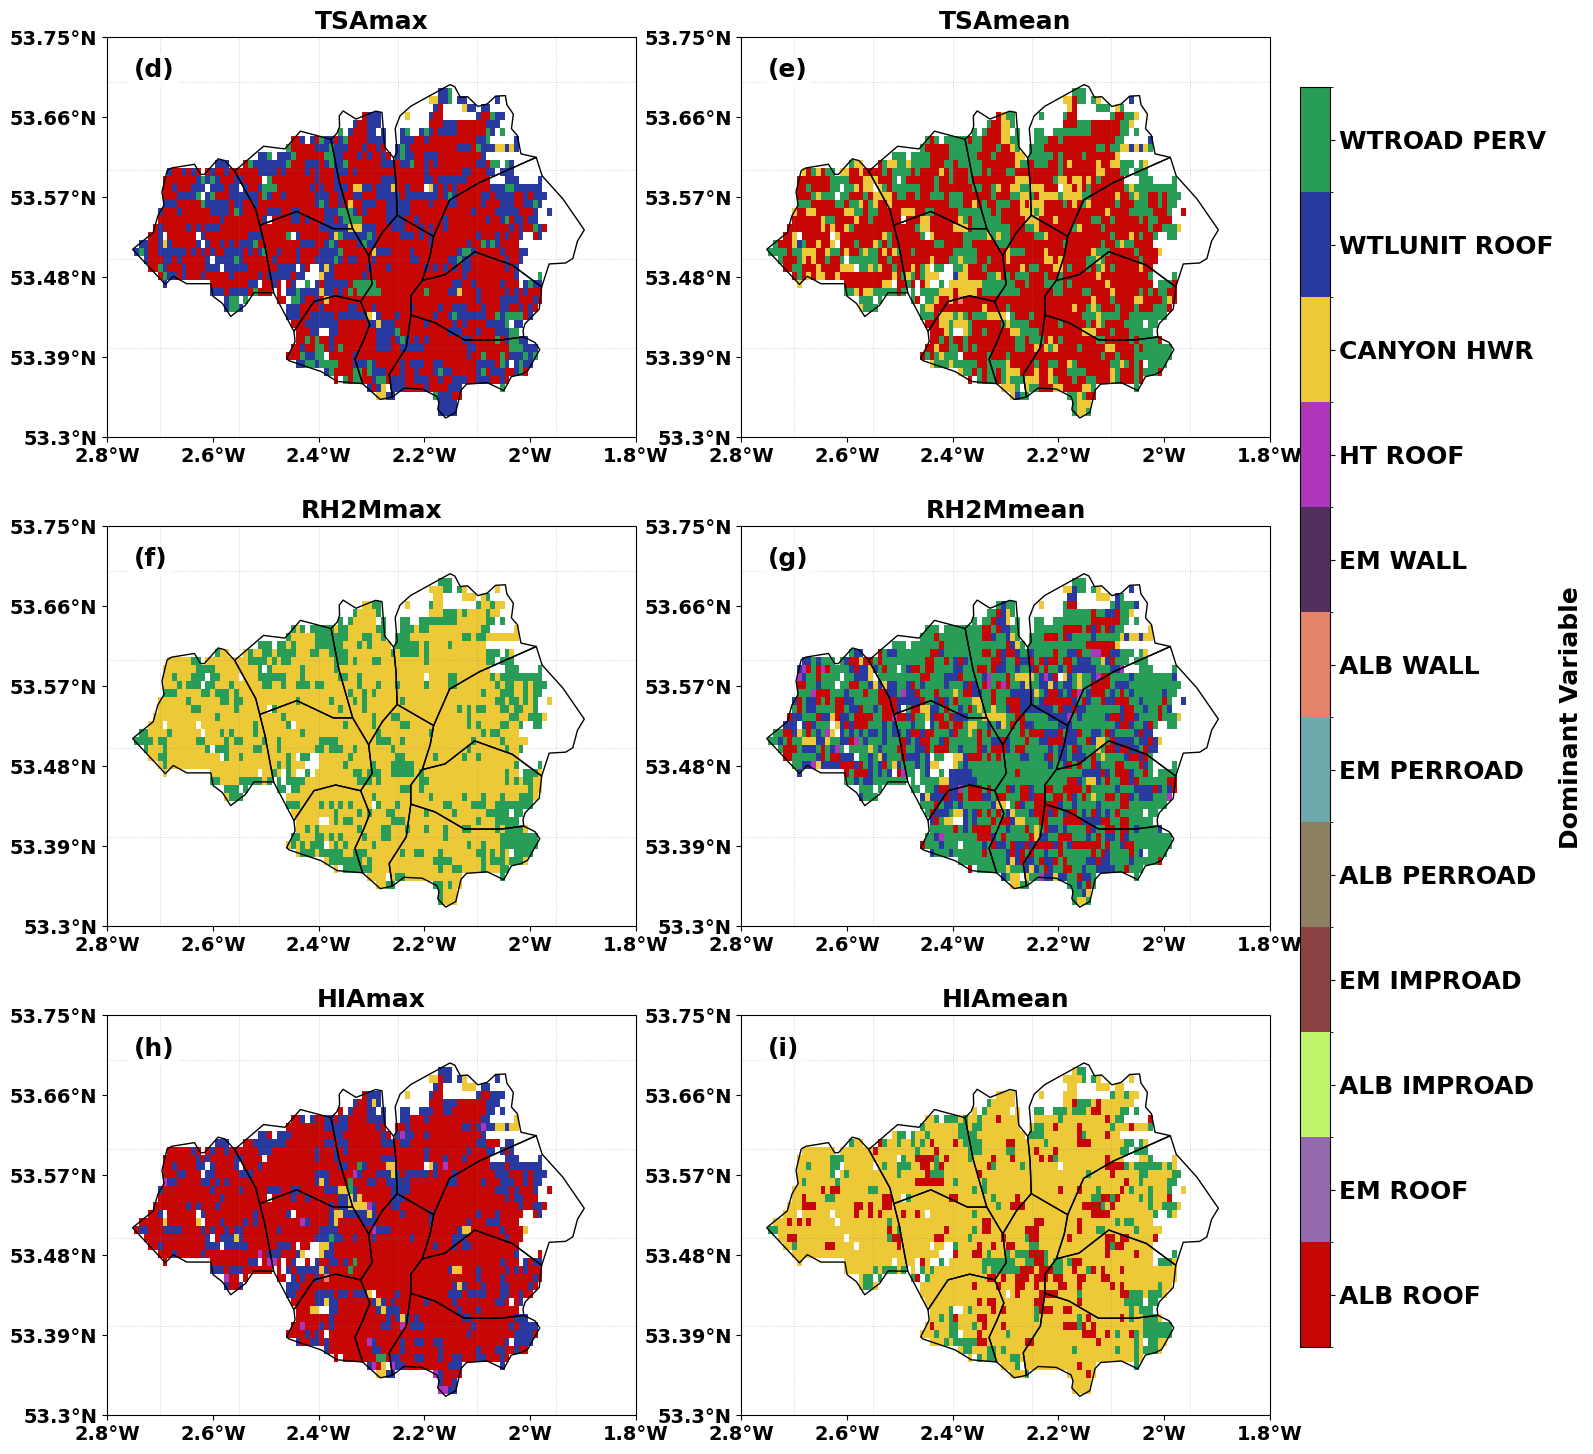

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
import pandas as pd

# --- 1. Data preparation ---
# Define target variables and feature names
target_names = ['TSAmax', 'TSAmean', 'RH2Mmax', 'RH2Mmean', 'HIAmax', 'HIAmean']
feature_names = ['ALB ROOF', 'EM ROOF', 'ALB IMPROAD', 'EM IMPROAD', 'ALB PERROAD',
                 'EM PERROAD', 'ALB WALL', 'EM WALL', 'HT ROOF', 'CANYON HWR',
                 'WTLUNIT ROOF', 'WTROAD PERV']

# Read longitude and latitude data
with Dataset(r'D:\A_sem2\ERP\Simulation\USurf_1km_netcdf\USurf_1km_netcdf\global_ALB_ROOF_1km_masked_gapfilled_QC.nc', mode='r') as nc:
    lon = nc.variables['lon'][:]
    lat = nc.variables['lat'][:]
    albroof_Man = nc.variables['ALB_ROOF'][lat_idx.min():lat_idx.max()+1, lon_idx.min():lon_idx.max()+1]

# Obtain invalid-value mask (True indicates invalid points)
nan_mask = np.isnan(albroof_Man)

# --- 2. Geographic data processing ---
# Extract Manchester region grid
lon_mask = (lon >= -2.8) & (lon <= -1.8)
lat_mask = (lat >= 53.3) & (lat <= 53.75)
lon_idx, lat_idx = np.where(lon_mask)[0], np.where(lat_mask)[0]
lon_Man, lat_Man = lon[lon_idx], lat[lat_idx]
lon_grid, lat_grid = np.meshgrid(lon_Man, lat_Man)

# Load Manchester administrative boundaries
districts = ['Manchester', 'Stockport', 'Wigan', 'Bolton', 'Salford',
             'Trafford', 'Tameside', 'Oldham', 'Rochdale', 'Bury']
gdf = gpd.read_file(r"D:/A_sem2/ERP/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
gdf_combined = gpd.GeoDataFrame(
    pd.concat([gdf[(gdf['name'] == d) & (gdf['iso_a2'] == 'GB')] for d in districts], axis=0),
    crs=gdf.crs
)

# --- 3. Visualization setup ---
# colors = plt.cm.Set3(np.linspace(0, 1, len(feature_names)))
colors = [
    "#C70606", "#9469AD", "#BFF46B", "#8A4343",  # ALB ROOF, EM ROOF, ALB IMPROAD, EM IMPROAD
    "#8D8062", "#6DAAAE", "#E3846A", "#52305D",  # ALB PERROAD, EM PERROAD, ALB WALL, EM WALL
    "#AD36BD", "#EDC938", "#283A9F", "#289D57"   # HT ROOF, CANYON HWR, WTLUNIT ROOF, WTROAD PERV
]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(feature_names) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# --- 4. Main plotting loop ---
fig, axes = plt.subplots(3, 2, figsize=(15, 18), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

plt.rcParams.update({
    'font.size': 20,                # global font size
    # 'font.weight': 'bold',        # global font weight (optional)
    'axes.titlesize': 18,           # axes title size
    'axes.titleweight': 'bold',     # axes title weight
    'axes.labelsize': 18,           # axes label size
    'axes.labelweight': 'bold',     # axes label weight
    'xtick.labelsize': 18,          # x tick label size
    'ytick.labelsize': 18,          # y tick label size
})

for i, target in enumerate(target_names):
    ax = axes[i]
    ax.set_extent([-2.8, -1.8, 53.3, 53.75], crs=ccrs.PlateCarree())

    # Load SHAP values and handle invalid points
    shap_values = np.load(f'ERP_automl_model_{target}_shap.npy')  # (5600, 12)
    max_shap_indices = np.argmax(np.abs(shap_values), axis=1)    # (5600,)
    max_shap_grid = max_shap_indices.reshape(nan_mask.shape).astype(float)  # convert to float (50, 112)

    # Key step: set SHAP index to NaN at invalid points
    max_shap_grid[nan_mask] = np.nan

    # Select valid points within Manchester region
    filtered_data = np.full_like(max_shap_grid, np.nan)
    points = [Point(x, y) for x, y in zip(lon_grid.flatten(), lat_grid.flatten())]
    mask = np.array([gdf_combined.unary_union.contains(pt) for pt in points]).reshape(nan_mask.shape)
    filtered_data[mask] = max_shap_grid[mask]

    # Plot heatmap
    im = ax.pcolormesh(lon_grid, lat_grid, filtered_data, cmap=cmap, norm=norm, shading='auto')
    gdf_combined.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    # ax.add_feature(cf.COASTLINE)
    ax.set_title(f'{target}')

    # ---- Add lon/lat ticks ----
    ax.tick_params(axis='both', which='major', labelsize=14)  # tick label size
    xticks = np.linspace(-2.8, -1.8, 6)
    yticks = np.linspace(53.3, 53.75, 6)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol="°"))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol="°"))
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle=':')

    # Add subplot label (d)-(i)
    subplot_label = chr(100 + i)  # 100 is ASCII code for 'd'
    ax.text(
        0.05, 0.90,                    # position (x, y) in axes coordinates (0-1)
        f'({subplot_label})',          # text content
        transform=ax.transAxes,        # use axes coordinate system
        fontsize=18,                   # font size
        weight='bold',                 # bold
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')  # optional background box
    )

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=np.arange(len(feature_names)))
cbar.set_label('Dominant Variable')
cbar.ax.set_yticklabels(feature_names)

# plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('ERP_most_importaant_feature.png', dpi=300, bbox_inches='tight')
plt.show()